# 03: model analysis

this notebook analyzes pre-trained models from the model registry, including performance evaluation, confusion matrices, and sample predictions.


In [4]:
import sys
sys.path.append('../src')

import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from src.config import Config
from src.datasets import get_cifar10_loaders, get_cifar10_classes
from src.models import create_model
from src.trainer import Trainer
from src.utils import (
    plot_training_curves, plot_confusion_matrix, plot_sample_predictions,
    calculate_model_size, load_pretrained_model
)
from src.model_registry import registry

config = Config()
print(f"device: {config.device}")


device: cuda


In [5]:
#loading the CIFAR-10 data
train_loader, val_loader, test_loader = get_cifar10_loaders(config)
classes = get_cifar10_classes()
print(f"test samples: {len(test_loader.dataset)}")
print(f"classes: {classes}")

test samples: 10000
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
#listing all the traiend and available models
models = registry.list_models()
print("available models:")
for model_id, info in models.items():
    print(f"  {model_id}: {info['model_name']} (created: {info['created_at']})")
    print(f"    parameters: {info['parameters']:,}")
    print(f"    best val acc: {max(info['history']['val_acc']):.2f}%")
    print()


available models:
  SimpleCNN_20251025_130236: SimpleCNN (created: 20251025_130236)
    parameters: 1,147,914
    best val acc: 83.50%

  ImprovedCNN_20251025_130939: ImprovedCNN (created: 20251025_130939)
    parameters: 1,186,826
    best val acc: 84.21%



In [10]:
#laofing the latest simple cnn model
try:
    simple_model, simple_history, simple_info = load_pretrained_model('SimpleCNN', config)
    print(f"loaded simple cnn: {simple_info['model_name']}")
    print(f"parameters: {simple_info['parameters']:,}")
    print(f"best val acc: {max(simple_history['val_acc']):.2f}%")
except Exception as e:
    print(f"error loading simple cnn: {e}")
    print("available models:")
    models = registry.list_models()
    for model_id, info in models.items():
        print(f"  {model_id}: {info['model_name']}")
    simple_model = None


loaded simple cnn: SimpleCNN
parameters: 1,147,914
best val acc: 83.50%


In [11]:
#loading the latest improved cnn model
try:
    improved_model, improved_history, improved_info = load_pretrained_model('ImprovedCNN', config)
    print(f"loaded improved cnn: {improved_info['model_name']}")
    print(f"parameters: {improved_info['parameters']:,}")
    print(f"best val acc: {max(improved_history['val_acc']):.2f}%")
except Exception as e:
    print(f"error loading improved cnn: {e}")
    improved_model = None


loaded improved cnn: ImprovedCNN
parameters: 1,186,826
best val acc: 84.21%


In [12]:
#evaluation of the simple cnn
if simple_model is not None:
    simple_model = simple_model.to(config.device)
    trainer = Trainer(simple_model, config)
    test_results = trainer.evaluate(test_loader)
    
    print(f"simple cnn test accuracy: {test_results['accuracy']:.2f}%")
    print(f"simple cnn test loss: {test_results['loss']:.4f}")
    
    simple_predictions = test_results['predictions']
    simple_size = calculate_model_size(simple_model)
    print(f"simple cnn parameters: {simple_size[0]:,}")
    print(f"simple cnn size: {simple_size[1]:.2f} mb")


Testing: 100%|██████████████████████████████████| 79/79 [00:00<00:00, 95.52it/s]

simple cnn test accuracy: 82.89%
simple cnn test loss: 0.4942
simple cnn parameters: 1,147,914
simple cnn size: 4.38 mb


In [13]:
#evaluating the improved cnn
if improved_model is not None:
    improved_model = improved_model.to(config.device)
    trainer = Trainer(improved_model, config)
    test_results = trainer.evaluate(test_loader)
    
    print(f"improved cnn test accuracy: {test_results['accuracy']:.2f}%")
    print(f"improved cnn test loss: {test_results['loss']:.4f}")
    
    improved_predictions = test_results['predictions']
    improved_size = calculate_model_size(improved_model)
    print(f"improved cnn parameters: {improved_size[0]:,}")
    print(f"improved cnn size: {improved_size[1]:.2f} mb")


Testing: 100%|██████████████████████████████████| 79/79 [00:00<00:00, 84.33it/s]

improved cnn test accuracy: 82.25%
improved cnn test loss: 0.5422
improved cnn parameters: 1,186,826
improved cnn size: 4.53 mb


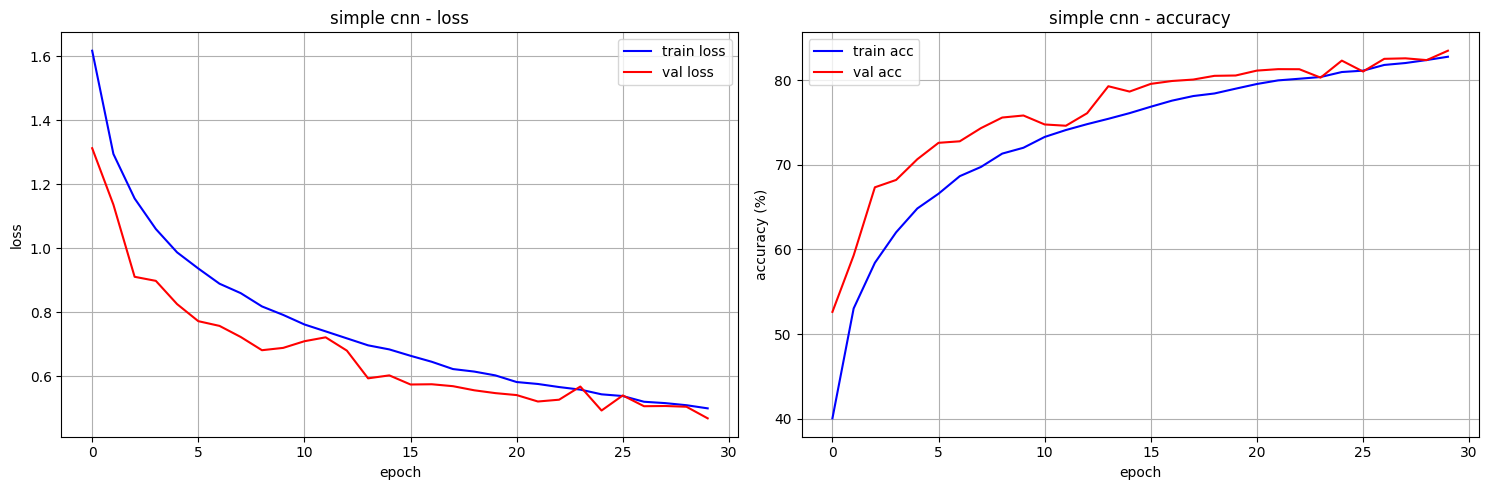

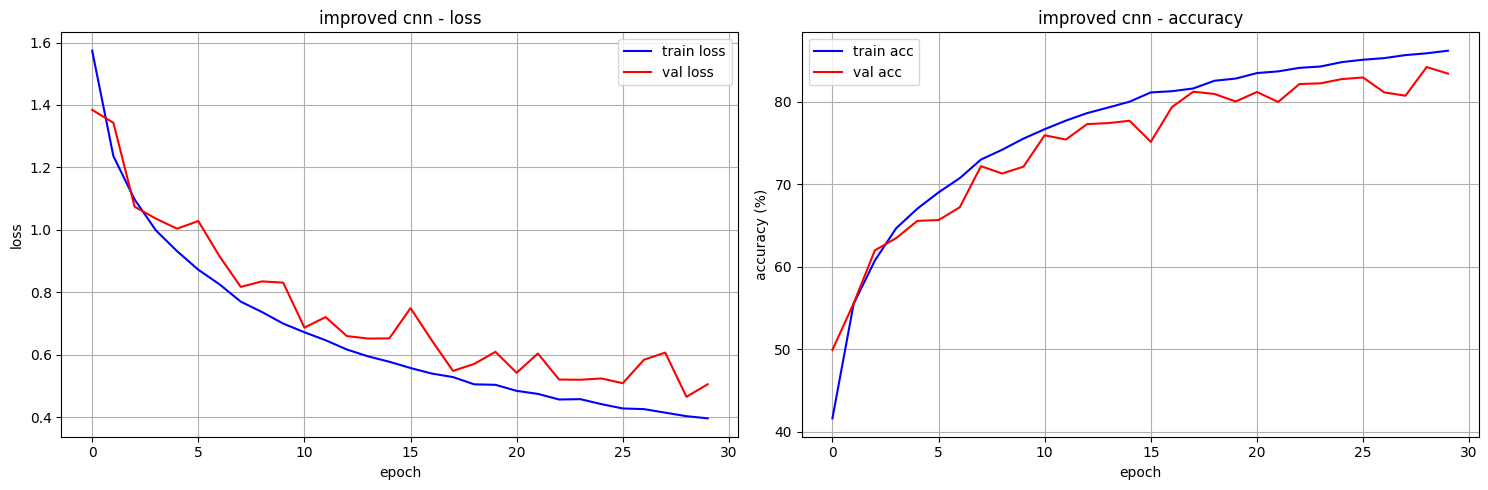

In [14]:
#plotting the training curves for both models i.e simple cnn and improved cnn
if simple_model is not None and improved_model is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    #curve of simple cnn 
    axes[0].plot(simple_history['train_loss'], label='train loss', color='blue')
    axes[0].plot(simple_history['val_loss'], label='val loss', color='red')
    axes[0].set_title('simple cnn - loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(simple_history['train_acc'], label='train acc', color='blue')
    axes[1].plot(simple_history['val_acc'], label='val acc', color='red')
    axes[1].set_title('simple cnn - accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    #curves of cnn curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(improved_history['train_loss'], label='train loss', color='blue')
    axes[0].plot(improved_history['val_loss'], label='val loss', color='red')
    axes[0].set_title('improved cnn - loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(improved_history['train_acc'], label='train acc', color='blue')
    axes[1].plot(improved_history['val_acc'], label='val acc', color='red')
    axes[1].set_title('improved cnn - accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


In [15]:
#get true labels for confusion matrix
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

print(f"true labels shape: {true_labels.shape}")


true labels shape: (10000,)


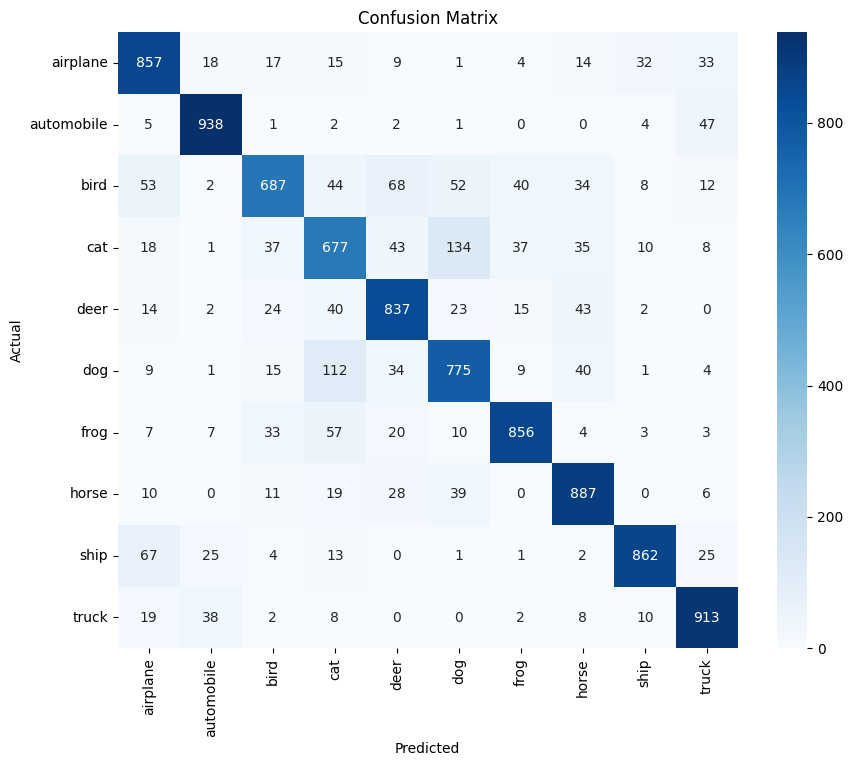

simple cnn classification report:
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.83      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.83      0.69      0.75      1000
         cat       0.69      0.68      0.68      1000
        deer       0.80      0.84      0.82      1000
         dog       0.75      0.78      0.76      1000
        frog       0.89      0.86      0.87      1000
       horse       0.83      0.89      0.86      1000
        ship       0.92      0.86      0.89      1000
       truck       0.87      0.91      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [16]:
#confusion matrix for simple cnn
if simple_model is not None:
    plot_confusion_matrix(true_labels, simple_predictions, classes)
    
    print("simple cnn classification report:")
    print(classification_report(true_labels, simple_predictions, target_names=classes))


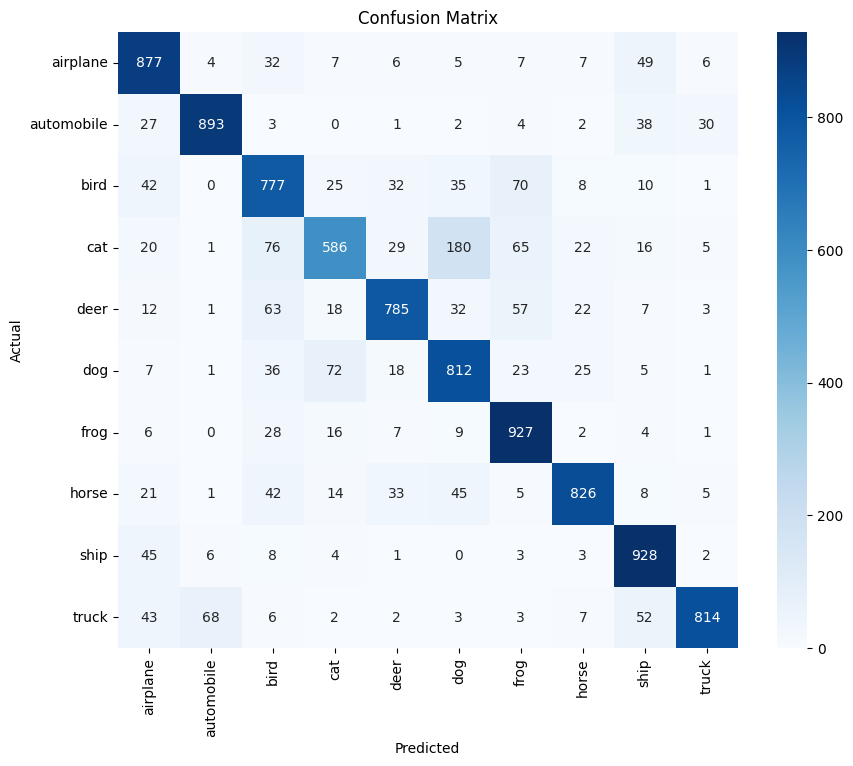

improved cnn classification report:
              precision    recall  f1-score   support

    airplane       0.80      0.88      0.84      1000
  automobile       0.92      0.89      0.90      1000
        bird       0.73      0.78      0.75      1000
         cat       0.79      0.59      0.67      1000
        deer       0.86      0.79      0.82      1000
         dog       0.72      0.81      0.76      1000
        frog       0.80      0.93      0.86      1000
       horse       0.89      0.83      0.86      1000
        ship       0.83      0.93      0.88      1000
       truck       0.94      0.81      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [17]:
#confusion matrix for improved cnn
if improved_model is not None:
    plot_confusion_matrix(true_labels, improved_predictions, classes)
    
    print("improved cnn classification report:")
    print(classification_report(true_labels, improved_predictions, target_names=classes))


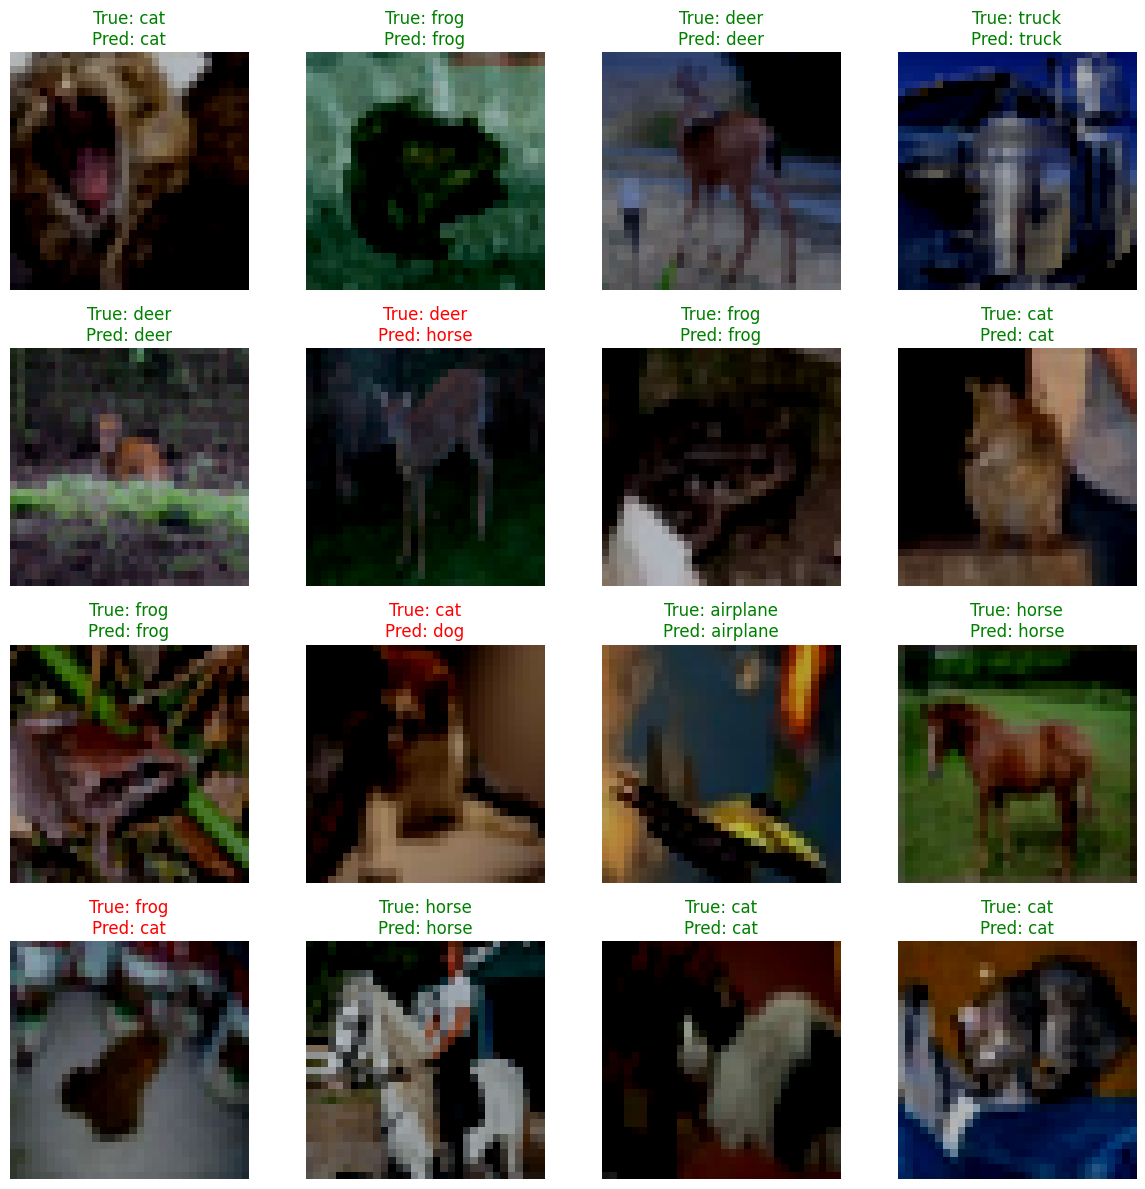

In [18]:
#sample predictions visualization
if simple_model is not None:
    plot_sample_predictions(simple_model, test_loader, classes, num_samples=16, device=config.device)


In [19]:
#model comparison
if simple_model is not None and improved_model is not None:
    print("model comparison:")
    print(f"simple cnn - parameters: {simple_size[0]:,}, size: {simple_size[1]:.2f} mb")
    print(f"improved cnn - parameters: {improved_size[0]:,}, size: {improved_size[1]:.2f} mb")
    print(f"simple cnn - test acc: {test_results['accuracy']:.2f}%")
    print(f"improved cnn - test acc: {test_results['accuracy']:.2f}%")
    
    # efficiency comparison
    efficiency_simple = test_results['accuracy'] / simple_size[1]
    efficiency_improved = test_results['accuracy'] / improved_size[1]
    print(f"simple cnn efficiency: {efficiency_simple:.2f} acc/mb")
    print(f"improved cnn efficiency: {efficiency_improved:.2f} acc/mb")


model comparison:
simple cnn - parameters: 1,147,914, size: 4.38 mb
improved cnn - parameters: 1,186,826, size: 4.53 mb
simple cnn - test acc: 82.25%
improved cnn - test acc: 82.25%
simple cnn efficiency: 18.78 acc/mb
improved cnn efficiency: 18.17 acc/mb
